In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
data = pd.read_csv("2024InternshipData.csv")

In [4]:
data.head()

,time_epoch,device_id,event_data,event_id
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",sessionFinished


In [5]:
data.shape

(107344, 4)

In [6]:
data.dtypes

time_epoch    float64
device_id      object
event_data     object
event_id       object
dtype: object

In [7]:
data.nunique()

time_epoch    107344
device_id       1514
event_data    107344
event_id           2
dtype: int64

In [ ]:
def to_dict(row):
    return json.loads(row['event_data'])

# creates new column containing data from 'event_data' column (dictionary)
data['event_data_dict'] = data.apply(to_dict, axis=1)

In [ ]:
# concatenates former dataset with data from 'event_data' dictionary
data_json = data['event_data_dict'].apply(pd.Series)
expanded_data = pd.concat([data.drop(columns=['event_data', 'event_data_dict']), data_json], axis=1)

In [ ]:
expanded_data['queryLength'] = expanded_data['searchStateFeatures'].apply(lambda x: x.get('queryLength'))

In [47]:
expanded_data.head(10)

,time_epoch,device_id,event_id,session_id,experimentGroup,searchStateFeatures,selectedIndexes,eventIndex,queryLength
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,{'queryLength': 11},None,0,11
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,{'queryLength': 12},None,1,12
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,{'queryLength': 13},None,2,13
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,{'queryLength': 14},None,3,14
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,sessionFinished,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,{'queryLength': 13},[0],4,13
5,1.699912e+12,c4b38243f41f4f3231ddc0360054cba4,searchRestarted,8d5a293be816112b74b32209dbdcac51,1,{'queryLength': 0},None,0,0
6,1.699912e+12,c4b38243f41f4f3231ddc0360054cba4,searchRestarted,8d5a293be816112b74b32209dbdcac51,1,{'queryLength': 1},None,1,1
7,1.699912e+12,c4b38243f41f4f3231ddc0360054cba4,searchRestarted,8d5a293be816112b74b32209dbdcac51,1,{'queryLength': 2},None,2,2
8,1.699912e+12,c4b38243f41f4f3231ddc0360054cba4,searchRestarted,8d5a293be816112b74b32209dbdcac51,1,{'queryLength': 1},None,3,1
9,1.699912e+12,c4b38243f41f4f3231ddc0360054cba4,searchRestarted,8d5a293be816112b74b32209dbdcac51,1,{'queryLength': 2},None,4,2


In [ ]:
# groups data by 'device_id' and 'session_id' (unique for every session)
expanded_grouped = expanded_data.groupby(['device_id', 'session_id'], as_index=False)
expanded_grouped = expanded_grouped.agg({'selectedIndexes': 'sum', 'time_epoch': ['min', 'max'], 'queryLength': 'mean', 'experimentGroup': 'min'})

expanded_grouped['time_spent'] = expanded_grouped['time_epoch']['max'] - expanded_grouped['time_epoch']['min']
expanded_grouped = expanded_grouped.drop(['time_epoch'], axis=1)

In [ ]:
# converts list containing one element to number (if empty number is equal to 100 - no result found)

def get_number(row):
    if row['selectedIndexes'].iloc[0]  == 0:
        return 100
    return row['selectedIndexes'].iloc[0][0]

expanded_grouped['selectedIndexes'] = expanded_grouped.apply(get_number, axis=1)

In [60]:
expanded_grouped.head()

,device_id,session_id,selectedIndexes,queryLength,experimentGroup,time_spent
,,,sum,mean,min,
0,0028cb12f73a5dee7cab800eea52877c,020f4452e355059af19f0a913d031778,11,1.500000,1,3.423420e+12
1,0028cb12f73a5dee7cab800eea52877c,22deb7b020cde724c2c0cc25b656286b,100,9.000000,1,3.421788e+12
2,0028cb12f73a5dee7cab800eea52877c,30ea57e277bf1e838fd73e4d14a50811,2,5.200000,1,3.415321e+12
3,0028cb12f73a5dee7cab800eea52877c,46ca22e8a357ad78a3091b237fec8f39,5,31.000000,1,3.433381e+12
4,0028cb12f73a5dee7cab800eea52877c,558a257eb566f98de09bb9b42ed57cf4,0,4.444444,1,3.413331e+12


In [ ]:
# creates dataframe from each experiment group
group0_grouped = expanded_grouped[expanded_grouped['experimentGroup']['min'] == 0].drop("experimentGroup", axis=1)
group1_grouped = expanded_grouped[expanded_grouped['experimentGroup']['min'] == 1].drop("experimentGroup", axis=1)

### Correlation among various metrics

In [ ]:
# calculating correlation among metrics for group zero
correlation0_1 = group0_grouped['selectedIndexes']['sum'].corr(group0_grouped['queryLength']['mean'], method='pearson')
correlation0_2 = group0_grouped['selectedIndexes']['sum'].corr(group0_grouped['time_spent'], method='pearson')
correlation0_3 = group0_grouped['time_spent'].corr(group0_grouped['queryLength']['mean'], method='pearson')

In [ ]:
# calculating correlation among metrics for group one
correlation1_1 = group1_grouped['selectedIndexes']['sum'].corr(group1_grouped['queryLength']['mean'], method='pearson')
correlation1_2 = group1_grouped['selectedIndexes']['sum'].corr(group1_grouped['time_spent'], method='pearson')
correlation1_3 = group1_grouped['time_spent'].corr(group1_grouped['queryLength']['mean'], method='pearson')

In [74]:
print(f"Correlation between 'selectedIndexes' and 'queryLength' in the experiment group zero is {round(correlation0_1.item(), 2)}")
print(f"Correlation between 'selectedIndexes' and 'time_spent' in the experiment group zero is {round(correlation0_2.item(), 2)}")
print(f"Correlation between 'time_spent' and 'queryLength' in the experiment group zero is {round(correlation0_3.item(), 2)}")
print()
print(f"Correlation between 'selectedIndexes' and 'queryLength' in the experiment group one is {round(correlation1_1.item(), 2)}")
print(f"Correlation between 'selectedIndexes' and 'time_spent' in the experiment group one is {round(correlation1_2.item(), 2)}")
print(f"Correlation between 'time_spent' and 'queryLength' in the experiment group one is {round(correlation1_3.item(), 2)}")

Correlation between 'selectedIndexes' and 'queryLength' in the experiment group zero is 0.01
Correlation between 'selectedIndexes' and 'time_spent' in the experiment group zero is -0.0
Correlation between 'time_spent' and 'queryLength' in the experiment group zero is -0.01

Correlation between 'selectedIndexes' and 'queryLength' in the experiment group one is -0.01
Correlation between 'selectedIndexes' and 'time_spent' in the experiment group one is -0.01
Correlation between 'time_spent' and 'queryLength' in the experiment group one is 0.01


In [24]:
data_plot0 = group0_grouped[(group0_grouped['selectedIndexes']['sum'] < 100) & (group0_grouped['queryLength']['mean'] < 100)]
data_plot1 = group1_grouped[(group1_grouped['selectedIndexes']['sum'] < 100) & (group1_grouped['queryLength']['mean'] < 100)]

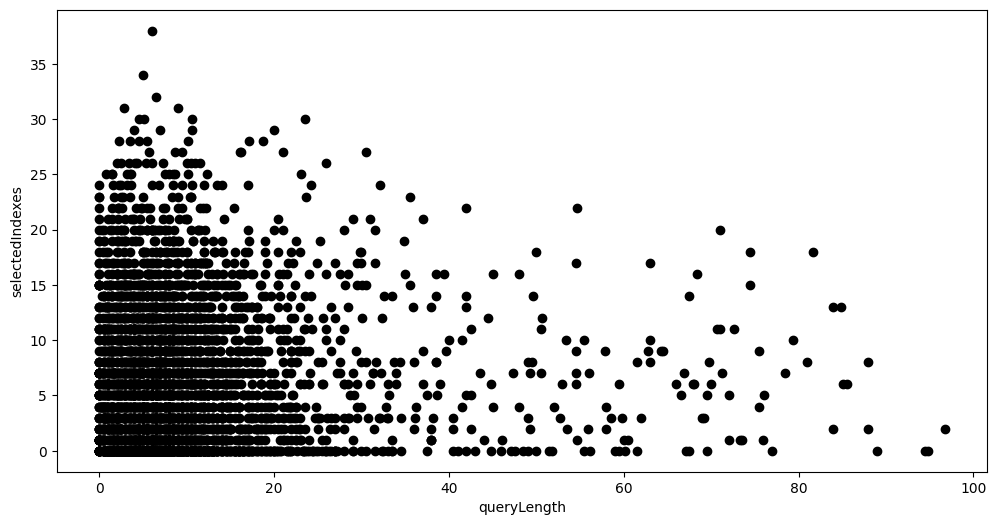

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(data_plot0['queryLength']['mean'], data_plot0['selectedIndexes']['sum'], color='black', marker='o')
plt.xlabel('queryLength')
plt.ylabel('selectedIndexes')
plt.show()


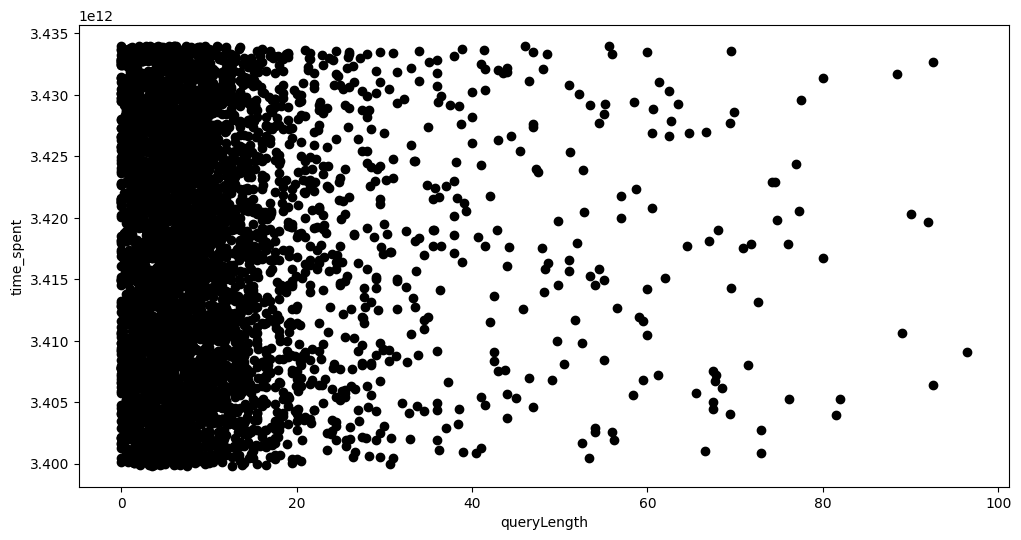

In [26]:
plt.figure(figsize=(12, 6))
plt.scatter(data_plot1['queryLength']['mean'], data_plot1['time_spent'], color='black', marker='o')
plt.xlabel('queryLength')
plt.ylabel('time_spent')
plt.show()

as we can see both the Pearson correlation test and the graphs does not show any correlation among time spent searching, number of selected index and query length

### Mean and median

#### Query length mean test

We want our model to produce relevant results without requiring too many input characters.

Null Hypothesis (H0): There is no difference in query length means between the two experiment groups (𝜇1 = 𝜇2)

Alternative Hypothesis (Ha): There is a difference in query length means between the two experiment groups (𝜇1 != 𝜇2)

significance level α=0.05

In [84]:
t_stat, p_value = stats.ttest_ind(data_plot0['queryLength']['mean'], data_plot1['queryLength']['mean'])
print(f"P-value is equal to {round(p_value, 3)}")

P-value is equal to 0.199


A p-value of 0.199 is greater than α=0.05, so we cannot reject null hypothesis -> there is no evidence to suggest that the two groups have different query length means

#### Selected index mean test

We want our model to place the most relevant search items at the top, so the mean of selected indexes should be low (ideally 0, indicating the top search result was clicked).

Null Hypothesis (H0): There is no difference in selected index means between the two experiment groups (𝜇1 = 𝜇2)

Alternative Hypothesis (Ha): There is a difference in selected index means between the two experiment groups (𝜇1 != 𝜇2)

significance level α=0.05

In [85]:
t_stat, p_value = stats.ttest_ind(data_plot0['selectedIndexes']['sum'], data_plot1['selectedIndexes']['sum'])
print(f"P-value is equal to {round(p_value, 3)}")

P-value is equal to 0.0


A p-value of 0 is less than α=0.05, so we reject the null hypothesis and conclude that there is a statistically significant difference between the mean of selected indexes of the two experiments.

In [87]:
print(f"Group zero mean: {round(data_plot0['selectedIndexes']['sum'].mean().item(), 2)} median: {round(data_plot0['selectedIndexes']['sum'].median().item(), 2)}")
print(f"Group one mean: {round(data_plot1['selectedIndexes']['sum'].mean().item(), 2)} median: {round(data_plot1['selectedIndexes']['sum'].median().item(), 2)}")

Group zero mean: 6.44 median: 5.0
Group one mean: 5.33 median: 4.0


Experiment group one seems to have better results

#### Time spent mean test

We want to minimize the time spent searching for results, aiming to reduce the interval between the start and end of the search.

Null Hypothesis (H0): There is no difference in time spent means between the two experiment groups (𝜇1 = 𝜇2)

Alternative Hypothesis (Ha): There is a difference in time spent means between the two experiment groups (𝜇1 != 𝜇2)

significance level α=0.05

In [86]:
t_stat, p_value = stats.ttest_ind(data_plot0['time_spent'], data_plot1['time_spent'])
print(f"P-value is equal to {round(p_value, 3)}")

P-value is equal to 0.876


A p-value of 0.876 is greater than α=0.05, so we cannot reject null hypothesis -> there is no evidence to suggest that the two groups have different time spent means

### No result found

The percentage of unsuccessful searches (searches that ended without any index selection)

In [44]:
not_found0 = group0_grouped[group0_grouped['selectedIndexes']['sum'] == 100]
group0_not_found = round((not_found0.shape[0]/group0_grouped.shape[0])*100, 2)
print(f"{group0_not_found} % from experiment group zero left the search bar without founding the result.")

42.66 % from experiment group zero left the search bar without founding the result.


In [45]:
not_found1 = group1_grouped[group1_grouped['selectedIndexes']['sum'] == 100]
group1_not_found = round((not_found1.shape[0]/group1_grouped.shape[0])*100, 2)
print(f"{group1_not_found} % from experiment group one left the search bar without founding the result.")

43.56 % from experiment group one left the search bar without founding the result.


Here experiment group zero has slightly better result.